In [1]:

import subprocess
from sklearn.metrics.pairwise import euclidean_distances
from bioimage_phenotyping import Cellprofiler

# from bioimage_phenotyping.features import features
import bioimage_phenotyping.shapes as shapes

subprocess.run("make get.data", shell=True)

wget -nc "https://zenodo.org/record/7267108/files/results_csv.zip"
unzip -n results_csv.zip
Archive:  results_csv.zip


File ‘results_csv.zip’ already there; not retrieving.



CompletedProcess(args='make get.data', returncode=0)

In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pathlib
import scipy
import warnings
from tqdm import tqdm
import dask.dataframe as dd
from sklearn import preprocessing

from bioimage_phenotyping import shapes, utils, features

# from bioimage_phenotyping import utils

warnings.filterwarnings("ignore")
sns.set()
from bioimage_phenotyping import Cellprofiler

# plt.ion()

VARIABLES = ["Conc /uM", "Date", "Drug"]
SAVE_FIG = True
SAVE_CSV = True
TEST_ROT = False

# kwargs_splinedist = {
#     "data_folder": "old_results/control_points",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


# kwargs_cellprofiler = {
#     "data_folder": "results/analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

# kwargs_cellprofiler = {
#     "data_folder": "old_results/analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

# kwargs_splinedist = {
#     "data_folder": "results/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


# kwargs_cellprofiler = {
#     "data_folder": "results/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

kwargs_splinedist = {
    "data_folder": "old_results/control_points",
    "nuclei_path": "objects_FilteredNuclei.csv",
}


kwargs_cellprofiler = {
    "data_folder": "old_results/analysed/cellprofiler/splinedist",
    "nuclei_path": "objects_FilteredNuclei.csv",
}

In [3]:


def save_csv(df, path):
    df.to_csv(metadata(path))
    return df


results_folder = f"results"
pathlib.Path(results_folder).mkdir(parents=True, exist_ok=True)


def metadata(x):
    path = pathlib.Path(results_folder, x)
    print(path)
    return path

In [4]:

def normalise_nd(arr):
    tmp = np.array(arr).ravel()
    bot = tmp.min()
    tmp = arr-tmp.min()
    top = tmp.max()
    return (arr-bot)/top

df_splinedist = (
    Cellprofiler(**kwargs_splinedist)
    .get_data()
    .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .pipe(normalise_nd)
    # .bip.preprocess()
    # .bip.preprocess()
    .bip.clean()
    .assign(Features="Control Points")
    .set_index(["Features"], append=True)
    # .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .sample(frac=1)
)

df_distance_matrix = (
    (df_splinedist
     .pipe(shapes.df_to_distance_matrix))
     .rename(index={"Control Points": "Control Points Dist"}, level="Features")
    .bip.preprocess()
)

df_distogram = (
    df_splinedist
     .pipe(shapes.df_to_distogram)
     .rename(index={"Control Points": "Distogram"}, level="Features")
    .bip.preprocess()
)

In [5]:

df_cellprofiler = (
    Cellprofiler(**kwargs_cellprofiler)
    .get_data()
    .bip.preprocess()
    .bip.clean()
    .assign(Features="CellProfiler")
    .set_index(["Features"], append=True)
    # .sample(32,axis=1,random_state=42)
)
df_cellprofiler.columns = df_cellprofiler.columns.str.replace("AreaShape_", "")

df = pd.concat([df_cellprofiler, df_splinedist, df_distance_matrix, df_distogram])

print(
    f'Organoids: {df.bip.grouped_median("ObjectNumber").bip.simple_counts()}',
    f"Nuclei: {df.bip.simple_counts()}",
)
# _, (a,b,c,d) = zip(*list((df.groupby("Features"))))

Organoids: 515 Nuclei: 37235


In [6]:

pca_objs_df = df.groupby("Features").apply(features.pca.fit_na)
pca_df = df.groupby("Features").apply(features.pca.fit_transform_na)

explained_variance_df = df.groupby("Features").apply(features.pca.explained_variance)

pca_components_df = df.groupby("Features").apply(features.pca.components)

component_melt = pd.melt(
    pca_components_df,
    var_name="Feature",
    value_name="Component Magnitude",
    ignore_index=False,
).set_index(["Feature"], append=True)


important_features = (
    component_melt.transform(abs)
    .reset_index()
    .sort_values("Component Magnitude", ascending=False)
    .drop_duplicates(["Features", "Principal Component"])
    .sort_values("Principal Component")
)

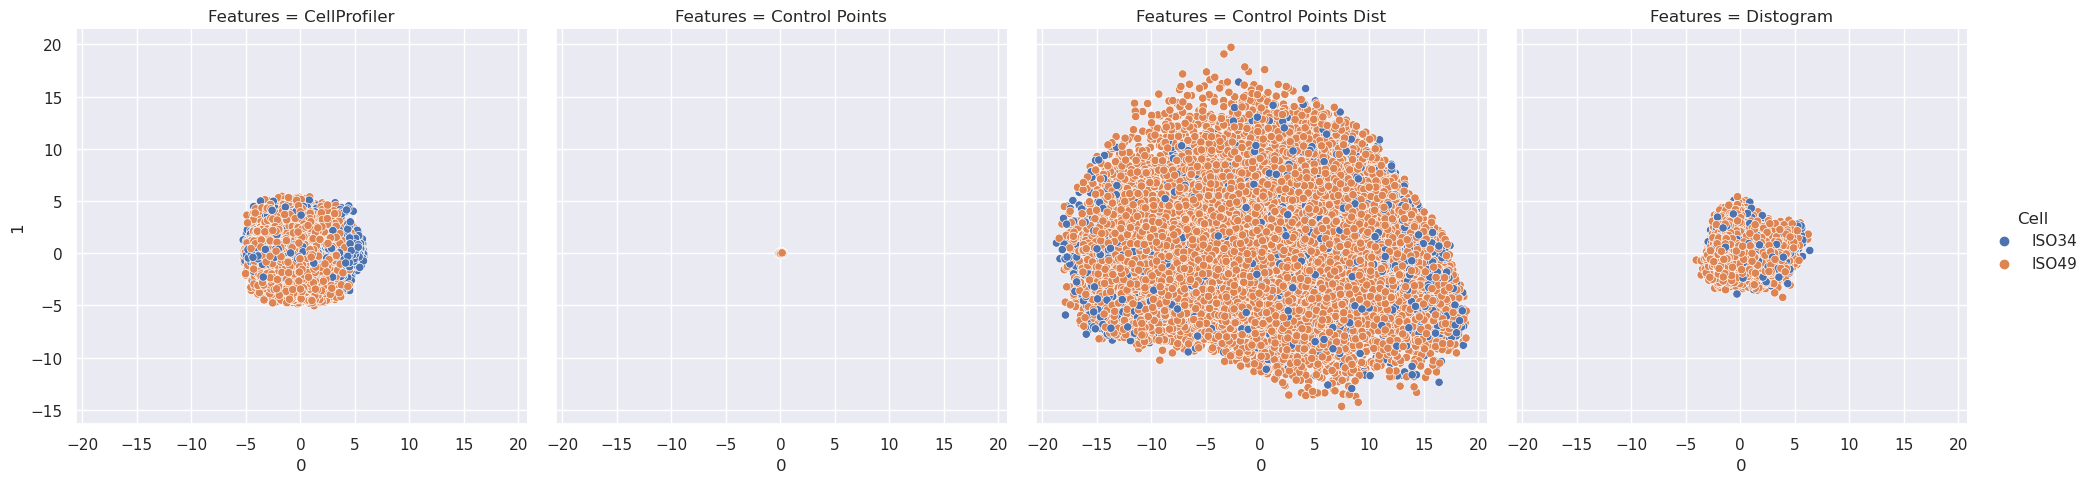

results/pca.pdf


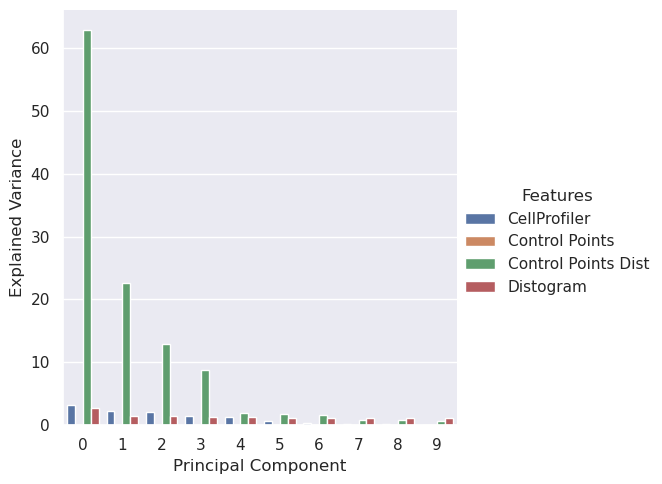

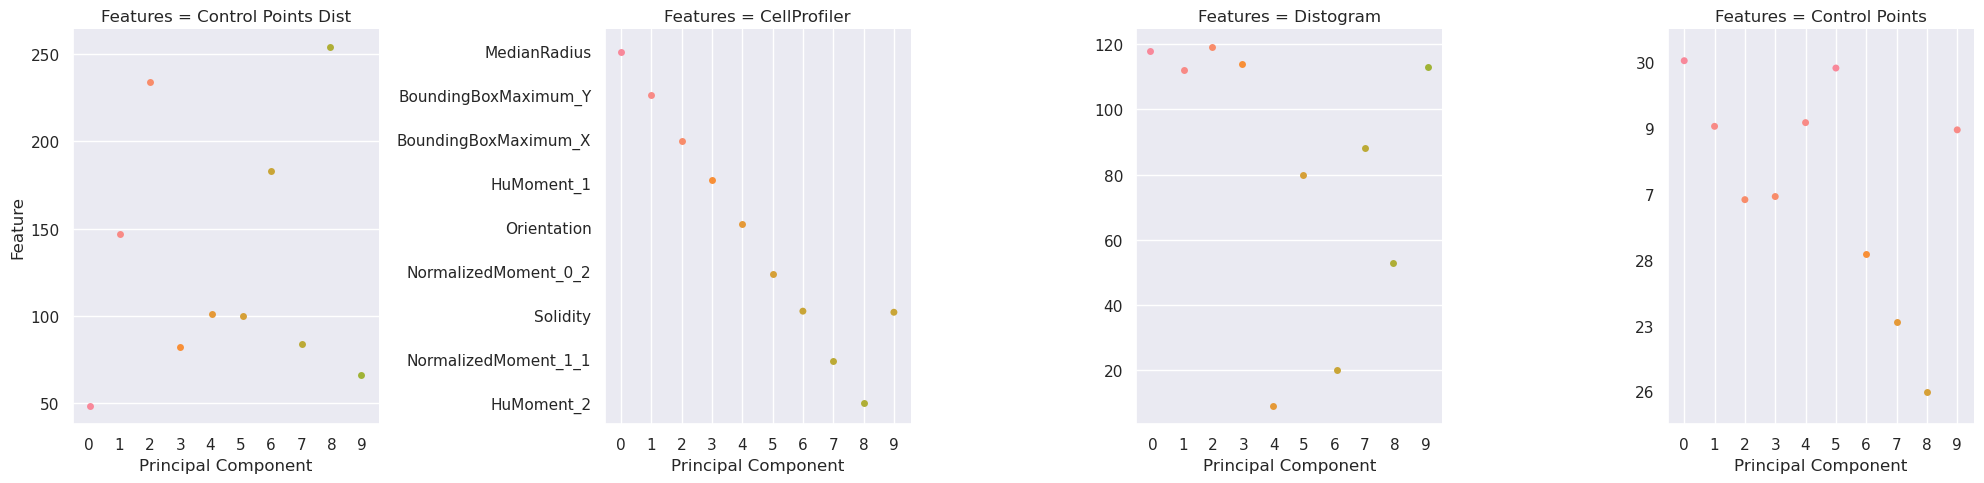

In [7]:
sns.relplot(data=pca_df, x=0, y=1, col="Features", hue="Cell")
plt.show()

# plt.figure()
sns.catplot(
    x="Principal Component",
    hue="Features",
    y="Explained Variance",
    data=explained_variance_df.reset_index(),
    legend_out=True,
    kind="bar",
)
plt.savefig(metadata("pca.pdf"), bbox_inches="tight")
plt.show()


# sns.catplot(
#     col="Principal Component",
#     y="Feature",
#     x="Component Magnitude",
#     sharey=False,
#     data=component_melt.reset_index(),
#     row="Features",
#     height=12,
# )
# plt.show()


sns.catplot(
    x="Principal Component",
    y="Feature",
    data=important_features.reset_index(),
    col="Features",
    sharey=False,
)
plt.show()


# df = df.iloc[:,random.sample(range(0, features), 32)]

results/fingerprints.pdf


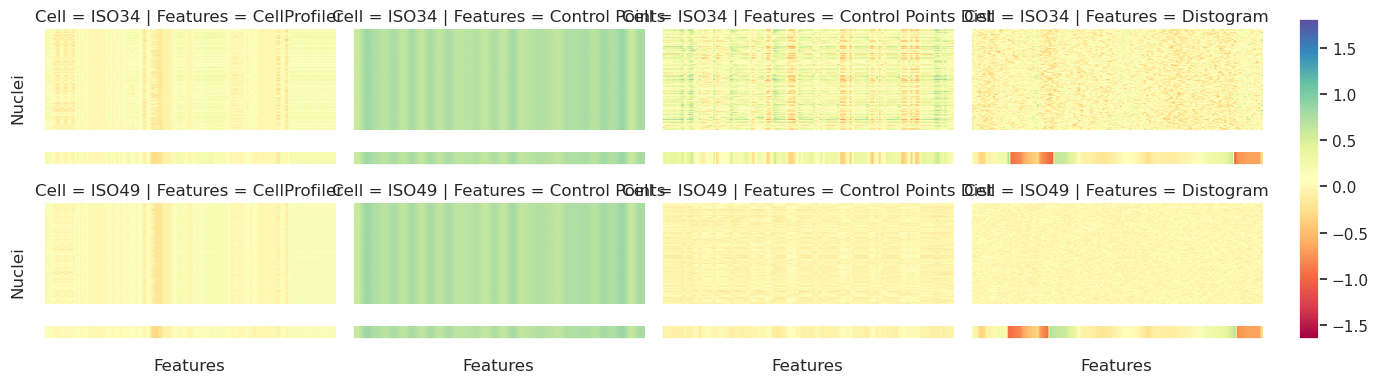

In [8]:


upper = np.nanmean(df.values.flatten()) + 2 * np.nanstd(df.values.flatten())
lower = np.nanmean(df.values.flatten()) - 2 * np.nanstd(df.values.flatten())


sns.set()
g = sns.FacetGrid(
    df.reset_index(level=["Cell", "Features"]),
    col="Features",
    row="Cell",
    height=2,
    aspect=1.61,
    sharey=False,
    sharex=False,
)
cax = g.fig.add_axes([1.015, 0.13, 0.015, 0.8])
g.map_dataframe(
    features.plotting.df_to_fingerprints_facet,
    "Features",
    "Nuclei",
    "Features",
    "Cell",
    cmap="Spectral",
    cbar=True,
    vmax=upper,vmin=lower,
)
plt.colorbar(cax=cax)
plt.savefig(metadata("fingerprints.pdf"), bbox_inches="tight")
plt.show()

In [9]:


augmentation = 0


def feature_importances(df, augment=None):
    return df.dropna(axis=1).bip.feature_importances(
        variable="Cell", kfolds=1, augment=augment
    )


def scoring(df, augment=None, kfolds=5):
    return df.dropna(axis=1).bip.get_scoring_df(
        variable="Cell", kfolds=kfolds, augment=augment
    )


spline_augment = lambda X, y: shapes.angular_augment_X_y(
    X, y, shapes.rotate_control_points_np, fold=augmentation
)

scoring_df = (
    df.groupby("Features")
    .apply(lambda df: df.bip.grouped_median("ObjectNumber").pipe(scoring))
    .reset_index("Features")
)

# scoring_df = df.groupby("Features").apply(
#     lambda df: df.pipe(scoring)
# ).reset_index("Features")

importance_df = (
    df.groupby("Features")
    .apply(lambda df: df.bip.grouped_median("ObjectNumber").pipe(feature_importances))
    .reset_index("Features")
)

# importance_df = df.groupby("Features").apply(
#     lambda df: df.pipe(feature_importances)
# ).reset_index("Features")


scoring_df_mean = scoring_df.groupby(["Metric", "Kind", "Variable", "Features"]).mean()
scoring_df_var = scoring_df.groupby(["Metric", "Kind", "Variable"]).var()

              precision    recall  f1-score   support

       ISO34       0.81      0.83      0.82        47
       ISO49       0.90      0.89      0.90        82

    accuracy                           0.87       129
   macro avg       0.86      0.86      0.86       129
weighted avg       0.87      0.87      0.87       129

0.7167764432390547


              precision    recall  f1-score   support

       ISO34       0.72      0.64      0.68        45
       ISO49       0.82      0.87      0.84        83

    accuracy                           0.79       128
   macro avg       0.77      0.76      0.76       128
weighted avg       0.79      0.79      0.79       128

0.5252747252747253


              precision    recall  f1-score   support

       ISO34       0.83      0.84      0.84        45
       ISO49       0.91      0.90      0.91        83

    accuracy                           0.88       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.88      0.88      0.88       128

0.7442727757059138
              precision    recall  f1-score   support

       ISO34       0.73      0.80      0.77        45
       ISO49       0.89      0.84      0.86        83

    accuracy                           0.83       128
   macro avg       0.81      0.82      0.82       128
weighted avg       0.83      0.83      0.83       128

0.630543164523747


results/scoring.pdf


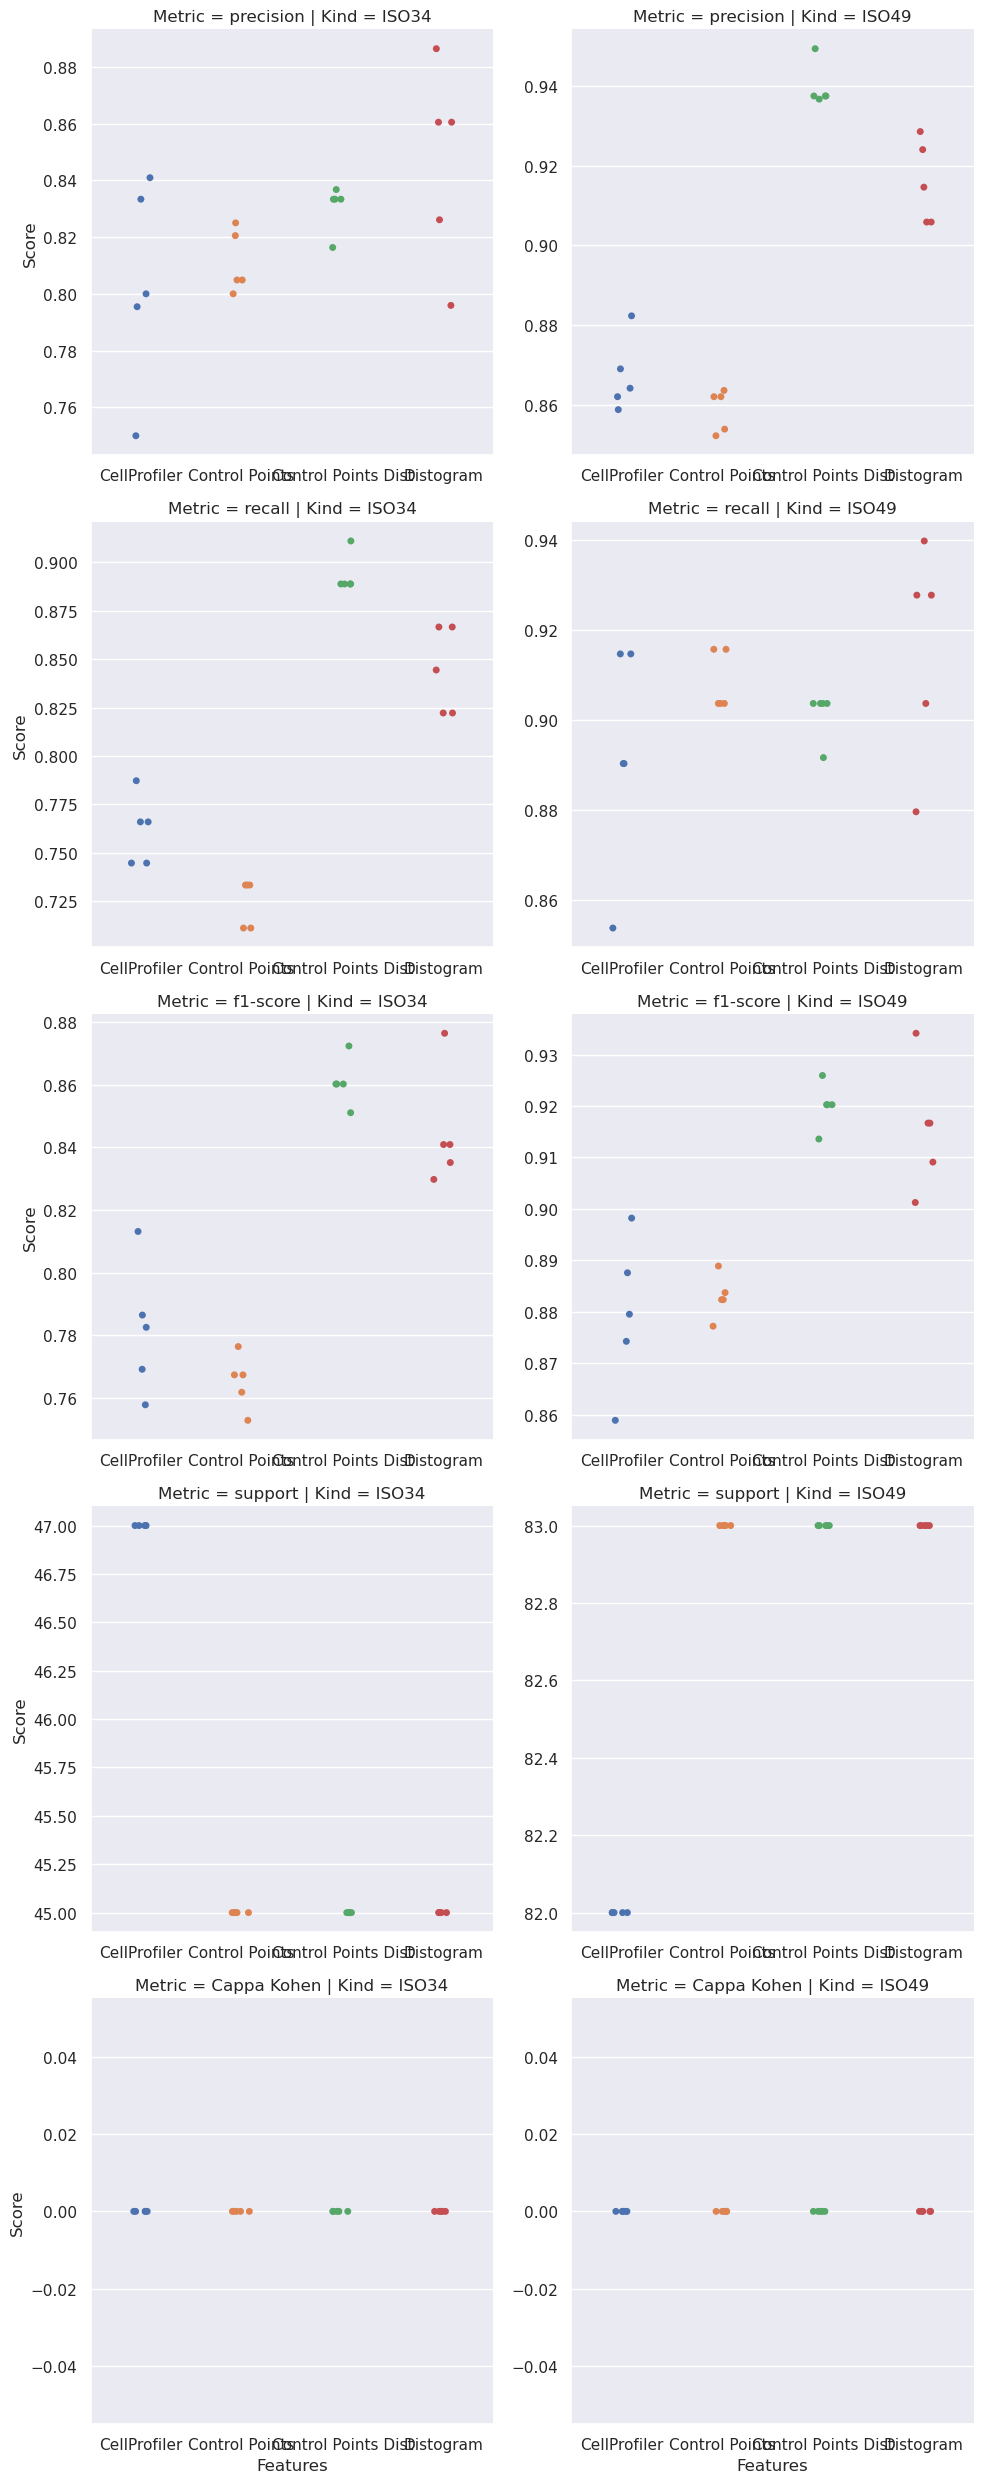

In [10]:
# data = scoring_df.reset_index("Features")
# data.to_csv("scoring_df.csv")
# sns.lmplot(
#     x="Augmentation",
#     y="Score",
#     col="Kind",
#     row="Metric",
#     hue="Features",
#     fit_reg=False,
#     sharey=False,
#     sharex=False,
#     x_ci="ci",
#     x_bins=5,
#     data=(scoring_df.reset_index("Features")),
# )

sns.catplot(
    # x="Augmentation",
    y="Score",
    col="Kind",
    row="Metric",
    x="Features",
    # fit_reg=False,
    sharey=False,
    sharex=False,
    # x_ci="ci",
    # x_bins=5,
    data=scoring_df,
)
plt.savefig(metadata("scoring.pdf"))
plt.show()
plt.close()

results/feature_importance.pdf


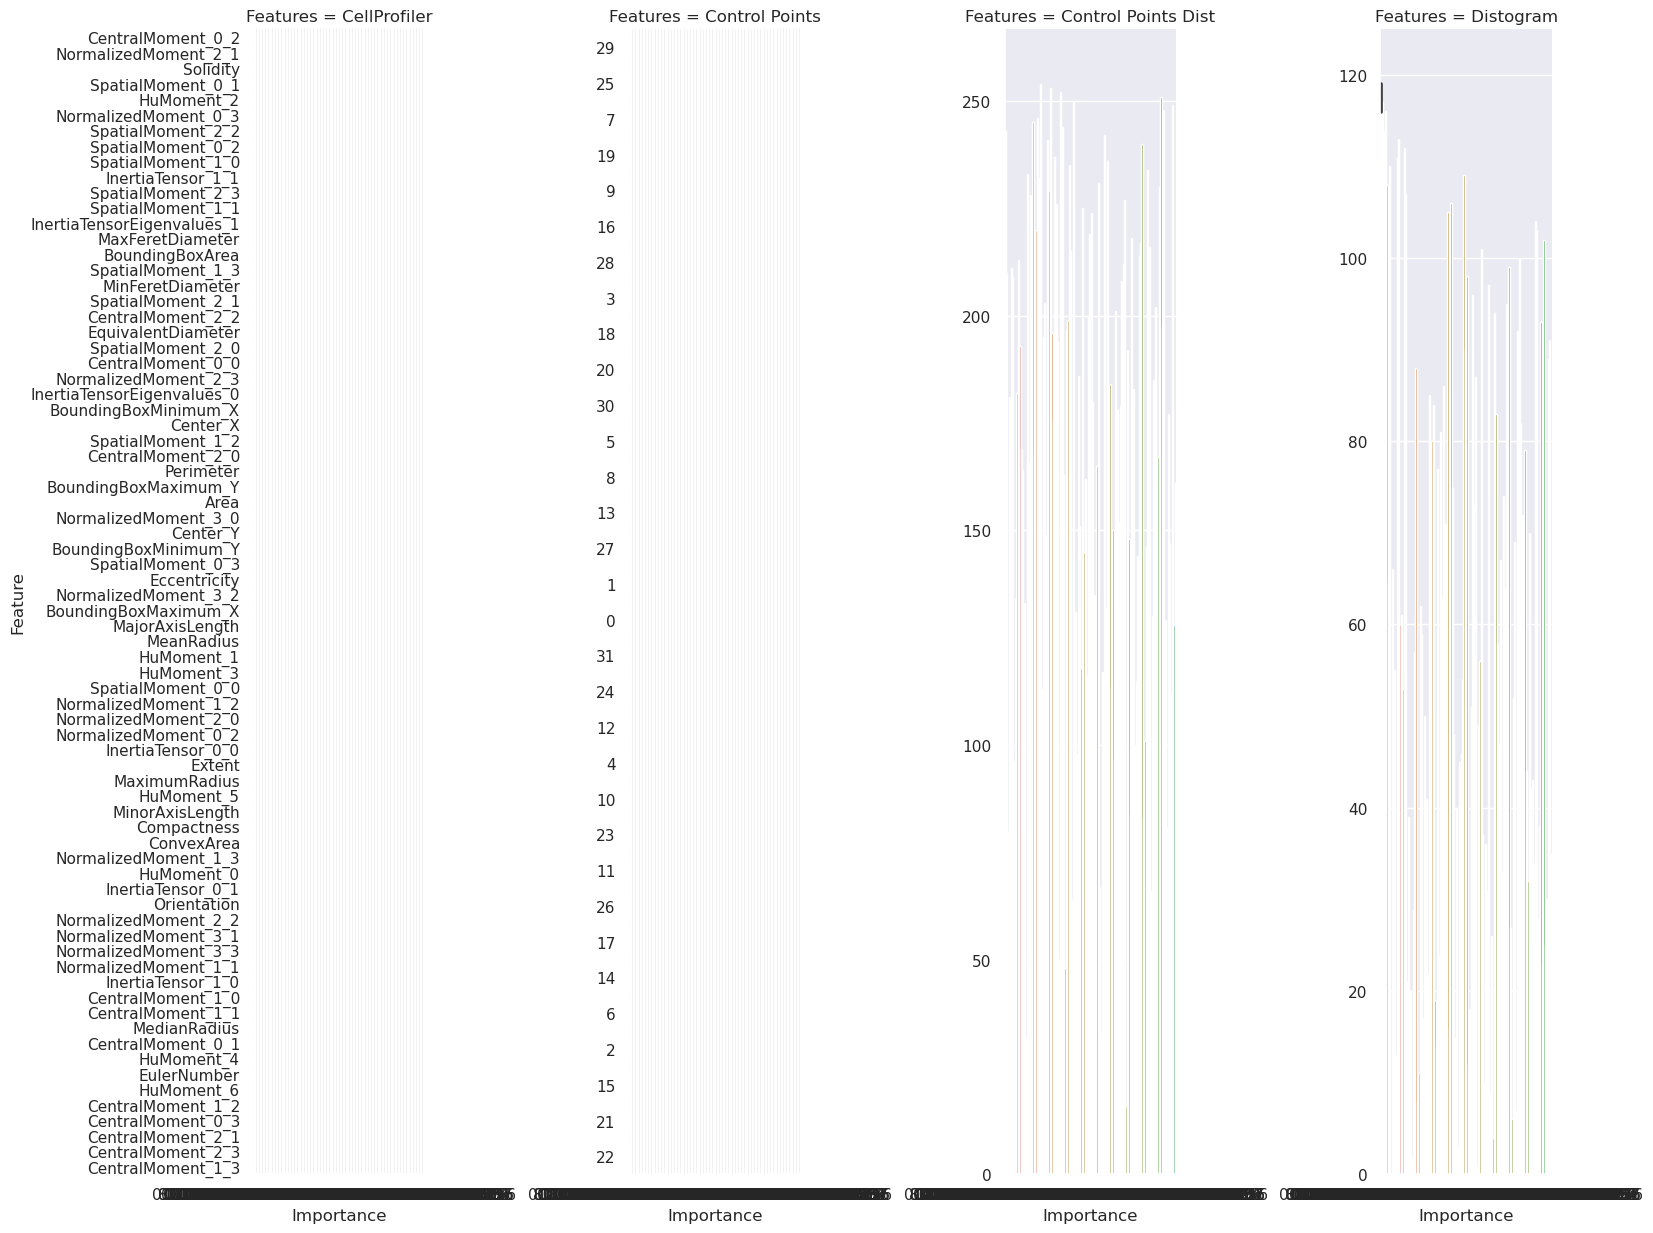

In [11]:
sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=(importance_df.reset_index()),
)
plt.savefig(metadata("feature_importance.pdf"))
plt.show()

In [12]:
import os

print("Exporting to notebook")
# os.system(f"jupytext --to notebook splines.py --update --execute")

Exporting to notebook
